In [64]:
import os
import numpy as np
import math
import sys
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

from WGAN import Generator, Discriminator

## Data Preparation

In [2]:
selected_sample = []
for i in range(10):
    img = Image.open('./sample/sample_'+str(i)+'.png')
    pixels = img.load()
    to_tensor = transforms.ToTensor()
    to_gray = transforms.Grayscale(num_output_channels=1)
    img = to_tensor(to_gray(img))
    selected_sample.append(img)

In [3]:
basic_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        #transforms.RandomRotation(degrees=(10, -10), fill=(0,)),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])
# 0,1,8
HV_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        transforms.RandomHorizontalFlip(p=0.4),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])
# 3
V_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        transforms.RandomVerticalFlip(p=0.4),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])

In [4]:
# get augmentation data
aug_data = []

for label,img in enumerate(selected_sample):
    aug_data.append([img,label])
    transform = basic_transform
    if label in [0,1,8]:
        transform = HV_transform
    elif label == 3:
        transform = V_transform
    for i in range(400):
        aug_data.append([transform(img),label])

# add more data up to 4096
while len(aug_data)%1024 != 0:
    for label,img in enumerate(selected_sample):
        transform = basic_transform
        if label in [0,1,8]:
            transform = HV_transform
        elif label == 3:
            transform = V_transform
        aug_data.append([transform(img),label])
        if len(aug_data)%1024 == 0:
            break

In [5]:
class aug_dataset(Dataset):
    def __init__(self,aug_data_list):
        self.aug_data_list = aug_data_list
    def __getitem__(self, idx):
        img = self.aug_data_list[idx][0]
        label = self.aug_data_list[idx][1]
        return img, label
    def __len__(self):
        return len(self.aug_data_list)

## Training

In [47]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).cuda()
    labels = labels.type(torch.LongTensor).cuda()
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).cuda()
    fake.requires_grad = False
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [67]:
lr = 0.0002
lambda_gp = 10
num_epochs = 200
latent_dim = 100

In [68]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [69]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
train_loader = DataLoader(aug_dataset(aug_data), batch_size=64, shuffle=True)

In [70]:
def D_train(real_imgs, labels, z):
    optimizer_D.zero_grad()
    # Generate a batch of images
    fake_imgs = generator(z, labels)

    # Real images
    real_validity = discriminator(real_imgs, labels)
    # Fake images
    fake_validity = discriminator(fake_imgs, labels)
    # Gradient penalty
    gradient_penalty = compute_gradient_penalty(
                        discriminator, real_imgs.data, fake_imgs.data,
                        labels.data)
    # Adversarial loss
    d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

    d_loss.backward()
    optimizer_D.step()
    return d_loss.item()

In [71]:
def G_train(labels, z):
    # Generate a batch of images
    fake_imgs = generator(z, labels)
    # Loss measures generator's ability to fool the discriminator
    # Train on fake images
    fake_validity = discriminator(fake_imgs, labels)
    g_loss = -torch.mean(fake_validity)

    g_loss.backward()
    optimizer_G.step()
    return g_loss.item()

[Epoch 0/200] [D loss: -1.613724] [G loss: 3.336697]


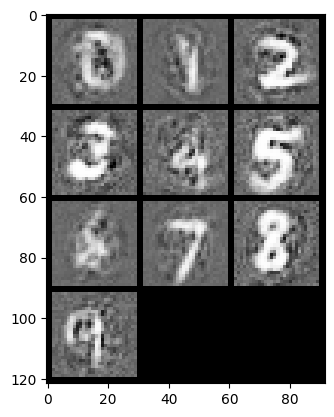

[Epoch 1/200] [D loss: -1.425549] [G loss: 3.251245]
[Epoch 2/200] [D loss: -1.782108] [G loss: 3.571356]
[Epoch 3/200] [D loss: -1.576984] [G loss: 2.868365]
[Epoch 4/200] [D loss: -1.127778] [G loss: 2.973794]
[Epoch 5/200] [D loss: -1.448867] [G loss: 3.217096]
[Epoch 6/200] [D loss: -1.332539] [G loss: 3.116263]
[Epoch 7/200] [D loss: -1.149849] [G loss: 3.038356]
[Epoch 8/200] [D loss: -1.472560] [G loss: 3.719741]
[Epoch 9/200] [D loss: -1.411743] [G loss: 3.118258]
[Epoch 10/200] [D loss: -1.674468] [G loss: 2.695439]


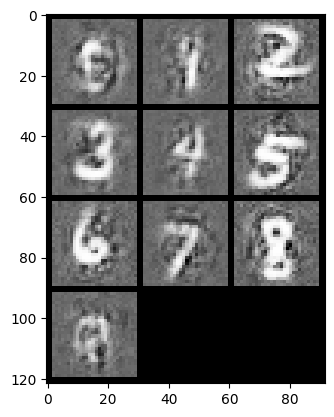

[Epoch 11/200] [D loss: -1.536739] [G loss: 3.193253]
[Epoch 12/200] [D loss: -1.470479] [G loss: 2.848167]
[Epoch 13/200] [D loss: -1.667729] [G loss: 3.477262]
[Epoch 14/200] [D loss: -1.684166] [G loss: 2.884437]
[Epoch 15/200] [D loss: -1.505423] [G loss: 2.846415]
[Epoch 16/200] [D loss: -1.333721] [G loss: 2.577171]
[Epoch 17/200] [D loss: -1.427112] [G loss: 2.762138]
[Epoch 18/200] [D loss: -1.518898] [G loss: 2.809313]
[Epoch 19/200] [D loss: -1.590374] [G loss: 2.849403]
[Epoch 20/200] [D loss: -1.497335] [G loss: 2.695222]


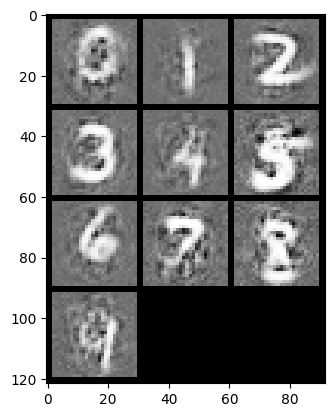

[Epoch 21/200] [D loss: -1.544494] [G loss: 2.813300]
[Epoch 22/200] [D loss: -1.364590] [G loss: 2.878759]
[Epoch 23/200] [D loss: -1.508507] [G loss: 2.587999]
[Epoch 24/200] [D loss: -1.479261] [G loss: 3.425539]
[Epoch 25/200] [D loss: -1.631580] [G loss: 3.459093]
[Epoch 26/200] [D loss: -1.258144] [G loss: 3.214658]
[Epoch 27/200] [D loss: -1.516461] [G loss: 2.966122]
[Epoch 28/200] [D loss: -1.423543] [G loss: 2.770062]
[Epoch 29/200] [D loss: -1.620584] [G loss: 3.441108]
[Epoch 30/200] [D loss: -1.428607] [G loss: 3.492067]


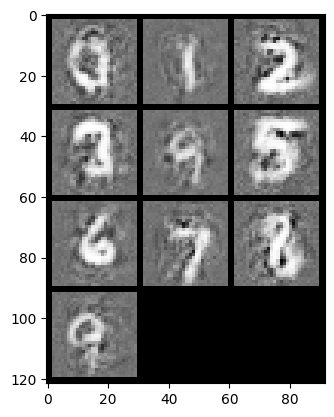

[Epoch 31/200] [D loss: -1.444268] [G loss: 3.270864]
[Epoch 32/200] [D loss: -1.338975] [G loss: 2.532548]
[Epoch 33/200] [D loss: -1.632569] [G loss: 3.436036]
[Epoch 34/200] [D loss: -1.480415] [G loss: 2.680604]
[Epoch 35/200] [D loss: -1.707332] [G loss: 2.496133]
[Epoch 36/200] [D loss: -1.574632] [G loss: 2.828474]
[Epoch 37/200] [D loss: -1.595472] [G loss: 3.197722]
[Epoch 38/200] [D loss: -1.637252] [G loss: 2.983108]
[Epoch 39/200] [D loss: -1.676797] [G loss: 3.060806]
[Epoch 40/200] [D loss: -1.330052] [G loss: 2.872218]


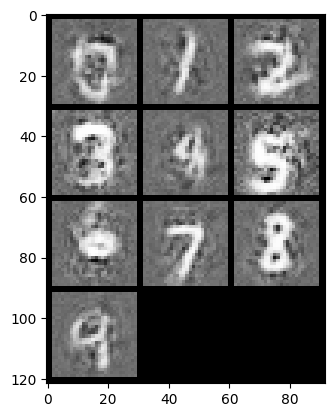

[Epoch 41/200] [D loss: -1.602636] [G loss: 2.686286]
[Epoch 42/200] [D loss: -1.530804] [G loss: 3.024584]
[Epoch 43/200] [D loss: -1.522961] [G loss: 3.147195]
[Epoch 44/200] [D loss: -1.475776] [G loss: 2.496176]
[Epoch 45/200] [D loss: -1.517024] [G loss: 3.114946]
[Epoch 46/200] [D loss: -1.609394] [G loss: 2.789278]
[Epoch 47/200] [D loss: -1.439298] [G loss: 2.594656]
[Epoch 48/200] [D loss: -1.548317] [G loss: 2.898482]
[Epoch 49/200] [D loss: -1.268812] [G loss: 3.157755]
[Epoch 50/200] [D loss: -1.574758] [G loss: 3.049605]


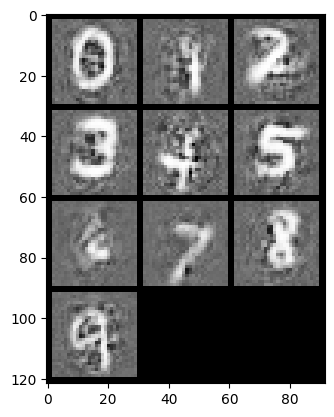

[Epoch 51/200] [D loss: -1.324059] [G loss: 3.288006]
[Epoch 52/200] [D loss: -1.400174] [G loss: 3.289373]
[Epoch 53/200] [D loss: -1.262972] [G loss: 2.835473]
[Epoch 54/200] [D loss: -1.403203] [G loss: 2.982928]
[Epoch 55/200] [D loss: -1.088504] [G loss: 2.822105]
[Epoch 56/200] [D loss: -1.611715] [G loss: 2.987574]
[Epoch 57/200] [D loss: -1.490027] [G loss: 3.000029]
[Epoch 58/200] [D loss: -1.382136] [G loss: 2.823375]
[Epoch 59/200] [D loss: -1.649261] [G loss: 2.926704]
[Epoch 60/200] [D loss: -1.502249] [G loss: 2.671617]


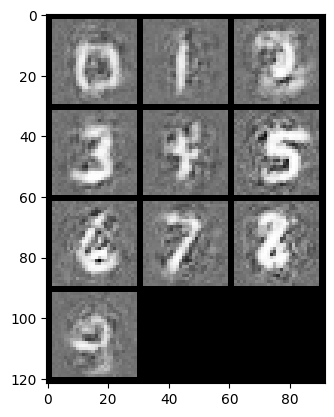

[Epoch 61/200] [D loss: -1.554073] [G loss: 2.802869]
[Epoch 62/200] [D loss: -1.481884] [G loss: 2.601565]
[Epoch 63/200] [D loss: -1.123776] [G loss: 3.219678]
[Epoch 64/200] [D loss: -1.275838] [G loss: 2.815454]
[Epoch 65/200] [D loss: -1.363549] [G loss: 2.968286]
[Epoch 66/200] [D loss: -1.120665] [G loss: 2.817857]
[Epoch 67/200] [D loss: -1.596313] [G loss: 2.948663]
[Epoch 68/200] [D loss: -1.517797] [G loss: 2.934506]
[Epoch 69/200] [D loss: -1.647379] [G loss: 3.533588]
[Epoch 70/200] [D loss: -1.416122] [G loss: 2.857478]


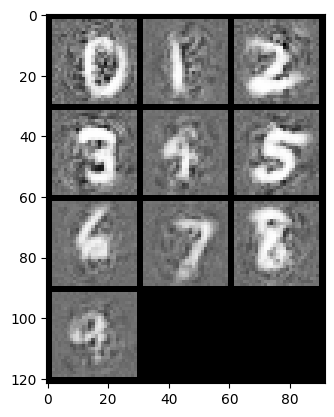

[Epoch 71/200] [D loss: -1.315332] [G loss: 3.130524]
[Epoch 72/200] [D loss: -1.380025] [G loss: 2.614543]
[Epoch 73/200] [D loss: -1.420650] [G loss: 3.065795]
[Epoch 74/200] [D loss: -1.800132] [G loss: 2.919718]
[Epoch 75/200] [D loss: -1.611494] [G loss: 2.787558]
[Epoch 76/200] [D loss: -1.327389] [G loss: 2.710386]
[Epoch 77/200] [D loss: -1.335637] [G loss: 2.950718]
[Epoch 78/200] [D loss: -1.413589] [G loss: 2.793476]
[Epoch 79/200] [D loss: -1.263427] [G loss: 3.119352]
[Epoch 80/200] [D loss: -1.324104] [G loss: 3.119048]


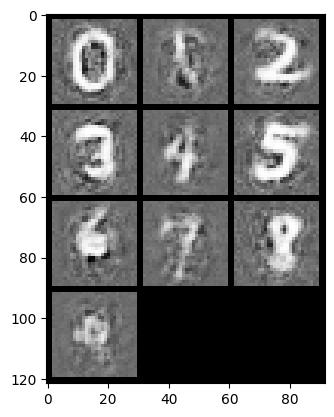

[Epoch 81/200] [D loss: -1.450651] [G loss: 3.044471]
[Epoch 82/200] [D loss: -1.636475] [G loss: 2.904958]
[Epoch 83/200] [D loss: -1.294539] [G loss: 2.888041]
[Epoch 84/200] [D loss: -1.390686] [G loss: 2.924262]
[Epoch 85/200] [D loss: -1.117812] [G loss: 2.582753]
[Epoch 86/200] [D loss: -1.200132] [G loss: 2.631716]
[Epoch 87/200] [D loss: -1.397021] [G loss: 2.646440]
[Epoch 88/200] [D loss: -1.395682] [G loss: 2.645089]
[Epoch 89/200] [D loss: -1.529509] [G loss: 2.727911]
[Epoch 90/200] [D loss: -1.411175] [G loss: 3.083026]


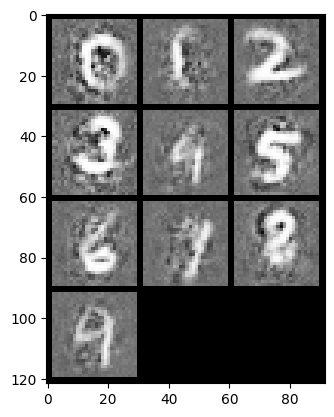

[Epoch 91/200] [D loss: -1.115153] [G loss: 2.956153]
[Epoch 92/200] [D loss: -1.225727] [G loss: 3.124731]
[Epoch 93/200] [D loss: -1.262797] [G loss: 3.406417]
[Epoch 94/200] [D loss: -1.576616] [G loss: 3.352907]
[Epoch 95/200] [D loss: -1.437319] [G loss: 2.560928]
[Epoch 96/200] [D loss: -1.447045] [G loss: 2.766344]
[Epoch 97/200] [D loss: -1.032599] [G loss: 2.884240]
[Epoch 98/200] [D loss: -1.508500] [G loss: 2.854219]
[Epoch 99/200] [D loss: -1.373930] [G loss: 2.666914]
[Epoch 100/200] [D loss: -1.176243] [G loss: 2.729981]


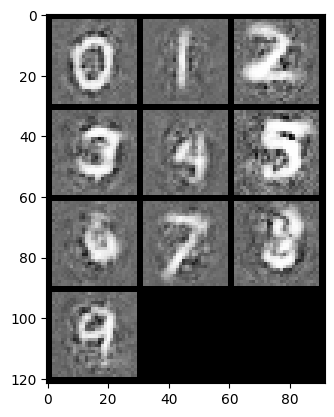

[Epoch 101/200] [D loss: -1.518838] [G loss: 2.534694]
[Epoch 102/200] [D loss: -1.312864] [G loss: 2.894667]
[Epoch 103/200] [D loss: -1.432001] [G loss: 2.674216]
[Epoch 104/200] [D loss: -1.449038] [G loss: 2.857079]
[Epoch 105/200] [D loss: -1.115028] [G loss: 2.489883]
[Epoch 106/200] [D loss: -1.480087] [G loss: 2.682259]
[Epoch 107/200] [D loss: -1.825252] [G loss: 2.975250]
[Epoch 108/200] [D loss: -1.595836] [G loss: 3.009457]
[Epoch 109/200] [D loss: -1.238635] [G loss: 2.745988]
[Epoch 110/200] [D loss: -1.406501] [G loss: 2.766521]


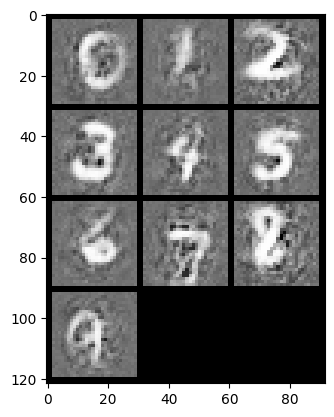

[Epoch 111/200] [D loss: -1.508227] [G loss: 2.516675]
[Epoch 112/200] [D loss: -0.860965] [G loss: 2.897763]
[Epoch 113/200] [D loss: -1.328731] [G loss: 2.794093]
[Epoch 114/200] [D loss: -1.207844] [G loss: 2.447363]
[Epoch 115/200] [D loss: -1.294212] [G loss: 2.776629]
[Epoch 116/200] [D loss: -1.383276] [G loss: 2.698587]
[Epoch 117/200] [D loss: -1.367781] [G loss: 2.730478]
[Epoch 118/200] [D loss: -1.311510] [G loss: 2.284286]
[Epoch 119/200] [D loss: -1.391843] [G loss: 2.903986]
[Epoch 120/200] [D loss: -1.379518] [G loss: 2.121844]


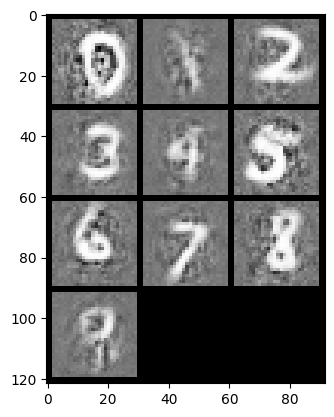

[Epoch 121/200] [D loss: -1.527591] [G loss: 2.391418]
[Epoch 122/200] [D loss: -1.395476] [G loss: 2.801721]
[Epoch 123/200] [D loss: -1.619830] [G loss: 2.728854]
[Epoch 124/200] [D loss: -1.303575] [G loss: 2.858608]
[Epoch 125/200] [D loss: -1.343942] [G loss: 2.801429]
[Epoch 126/200] [D loss: -1.573754] [G loss: 2.446643]
[Epoch 127/200] [D loss: -1.434821] [G loss: 2.692252]
[Epoch 128/200] [D loss: -1.474148] [G loss: 2.606767]
[Epoch 129/200] [D loss: -1.352927] [G loss: 2.221169]
[Epoch 130/200] [D loss: -1.178783] [G loss: 2.427701]


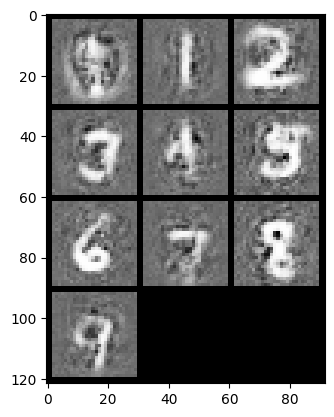

[Epoch 131/200] [D loss: -1.417983] [G loss: 2.165533]
[Epoch 132/200] [D loss: -1.284404] [G loss: 2.596105]
[Epoch 133/200] [D loss: -1.381201] [G loss: 2.936381]
[Epoch 134/200] [D loss: -1.376161] [G loss: 3.097573]
[Epoch 135/200] [D loss: -1.482315] [G loss: 2.902286]
[Epoch 136/200] [D loss: -1.003807] [G loss: 2.564248]
[Epoch 137/200] [D loss: -1.251902] [G loss: 2.383273]
[Epoch 138/200] [D loss: -1.318449] [G loss: 3.007506]
[Epoch 139/200] [D loss: -1.447902] [G loss: 2.530308]
[Epoch 140/200] [D loss: -1.170635] [G loss: 2.430027]


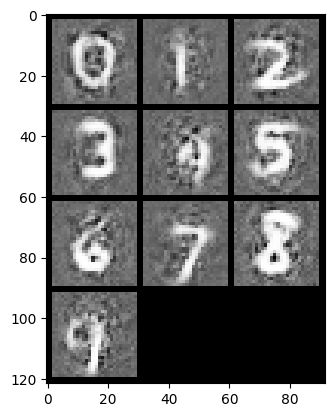

[Epoch 141/200] [D loss: -1.271934] [G loss: 2.970971]
[Epoch 142/200] [D loss: -1.337268] [G loss: 2.321833]
[Epoch 143/200] [D loss: -1.380009] [G loss: 2.774882]
[Epoch 144/200] [D loss: -1.315671] [G loss: 2.482079]
[Epoch 145/200] [D loss: -0.872877] [G loss: 2.557140]
[Epoch 146/200] [D loss: -1.552689] [G loss: 2.579543]
[Epoch 147/200] [D loss: -1.219049] [G loss: 2.671301]
[Epoch 148/200] [D loss: -1.326291] [G loss: 2.580963]
[Epoch 149/200] [D loss: -1.194951] [G loss: 2.684123]
[Epoch 150/200] [D loss: -1.254137] [G loss: 3.097404]


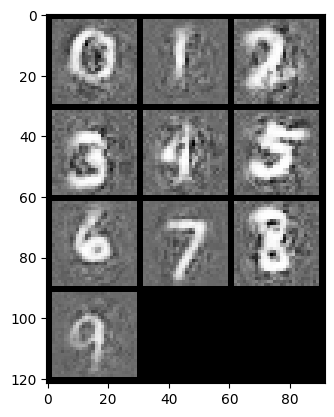

[Epoch 151/200] [D loss: -1.473800] [G loss: 2.449448]
[Epoch 152/200] [D loss: -1.470114] [G loss: 2.510003]
[Epoch 153/200] [D loss: -1.149809] [G loss: 2.297373]
[Epoch 154/200] [D loss: -1.487818] [G loss: 2.892855]
[Epoch 155/200] [D loss: -1.421148] [G loss: 2.517614]
[Epoch 156/200] [D loss: -1.558055] [G loss: 2.178902]
[Epoch 157/200] [D loss: -1.287712] [G loss: 2.696301]
[Epoch 158/200] [D loss: -1.179774] [G loss: 2.832688]
[Epoch 159/200] [D loss: -1.219716] [G loss: 2.607069]
[Epoch 160/200] [D loss: -1.382909] [G loss: 2.195160]


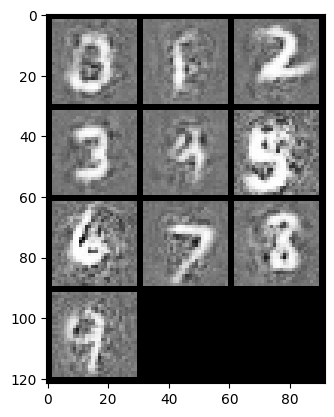

[Epoch 161/200] [D loss: -1.211974] [G loss: 2.140813]
[Epoch 162/200] [D loss: -1.086921] [G loss: 2.503450]
[Epoch 163/200] [D loss: -1.505402] [G loss: 2.671018]
[Epoch 164/200] [D loss: -1.466050] [G loss: 2.388186]
[Epoch 165/200] [D loss: -1.457293] [G loss: 2.284986]
[Epoch 166/200] [D loss: -1.398703] [G loss: 2.254113]
[Epoch 167/200] [D loss: -1.315232] [G loss: 2.544876]
[Epoch 168/200] [D loss: -1.439873] [G loss: 1.996191]
[Epoch 169/200] [D loss: -1.356314] [G loss: 2.723212]
[Epoch 170/200] [D loss: -1.330579] [G loss: 2.135158]


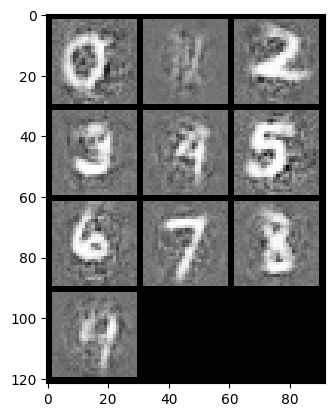

[Epoch 171/200] [D loss: -1.085948] [G loss: 2.693748]
[Epoch 172/200] [D loss: -1.441394] [G loss: 2.166359]
[Epoch 173/200] [D loss: -1.315526] [G loss: 2.081050]
[Epoch 174/200] [D loss: -1.129350] [G loss: 2.513204]
[Epoch 175/200] [D loss: -1.244470] [G loss: 1.887224]
[Epoch 176/200] [D loss: -1.484828] [G loss: 2.494415]
[Epoch 177/200] [D loss: -1.522387] [G loss: 1.949425]
[Epoch 178/200] [D loss: -1.302024] [G loss: 1.982713]
[Epoch 179/200] [D loss: -1.203712] [G loss: 2.046142]
[Epoch 180/200] [D loss: -1.220089] [G loss: 2.298434]


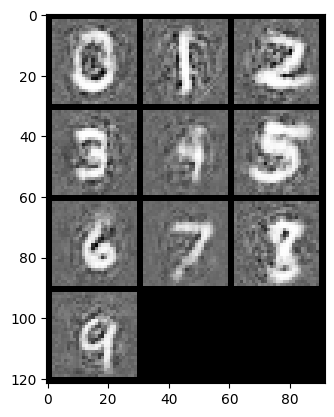

[Epoch 181/200] [D loss: -1.081583] [G loss: 2.451914]
[Epoch 182/200] [D loss: -1.180507] [G loss: 2.438139]
[Epoch 183/200] [D loss: -1.509319] [G loss: 2.247355]
[Epoch 184/200] [D loss: -1.232508] [G loss: 2.292835]
[Epoch 185/200] [D loss: -1.115417] [G loss: 2.561561]
[Epoch 186/200] [D loss: -1.142952] [G loss: 2.042974]
[Epoch 187/200] [D loss: -1.223726] [G loss: 2.105000]
[Epoch 188/200] [D loss: -1.586472] [G loss: 2.184093]
[Epoch 189/200] [D loss: -1.069106] [G loss: 2.371980]
[Epoch 190/200] [D loss: -1.375693] [G loss: 1.979570]


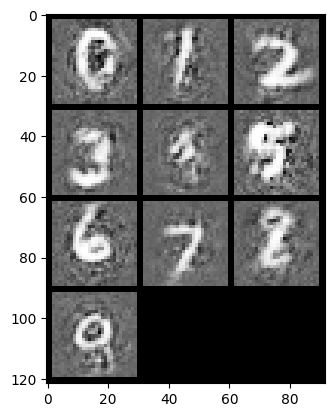

[Epoch 191/200] [D loss: -1.352637] [G loss: 2.333211]
[Epoch 192/200] [D loss: -1.300931] [G loss: 2.262955]
[Epoch 193/200] [D loss: -1.286500] [G loss: 2.380973]
[Epoch 194/200] [D loss: -1.189022] [G loss: 2.407872]
[Epoch 195/200] [D loss: -1.311218] [G loss: 2.523299]
[Epoch 196/200] [D loss: -1.203526] [G loss: 2.503263]
[Epoch 197/200] [D loss: -1.375362] [G loss: 2.243762]
[Epoch 198/200] [D loss: -1.180535] [G loss: 2.263488]
[Epoch 199/200] [D loss: -1.474866] [G loss: 1.856453]


In [74]:
batches_done = 0
n_critic = 5
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.shape[0]
        real_imgs = imgs.cuda()
        labels = labels.cuda()
         # Sample noise and labels as generator input
        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))).cuda()
        d_loss = D_train(real_imgs, labels, z)

        optimizer_G.zero_grad()
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            g_loss = G_train(labels, z)
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, num_epochs, d_loss, g_loss)
    )
    if epoch % 10 == 0:
        with torch.no_grad():
            generator.eval()
            z = torch.Tensor(np.random.normal(0, 1, (10, latent_dim))).cuda()
            labels = torch.LongTensor(np.arange(10)).cuda()
            sample_images = generator(z, labels).view(10,1,28,28).detach().cpu()
            grid = torchvision.utils.make_grid(sample_images, nrow=3, normalize=True)
            grid = grid.numpy().transpose(1, 2, 0)
            plt.imshow(grid, cmap=plt.get_cmap('gray'))
            plt.show()

In [75]:
torch.save(generator, './model_checkpoint/Wgenerator.pt')

In [77]:
generator = generator.cuda()
rand_int = np.random.randint(0,10,size=2048)
labels = torch.LongTensor(rand_int).cuda()
z = torch.randn(2048, 100).cuda()
gen_image = generator(z, labels).view(2048,1,28,28).detach().cpu()